In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import tensorflow as tf
import random
import datetime

from neuralNetwork import *
from batchMaker import *

/home/padmarajbhatpaddy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


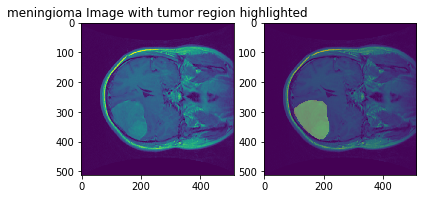

This is how the data is fed to CNN: 
original image with the tumor and its 3 rotations


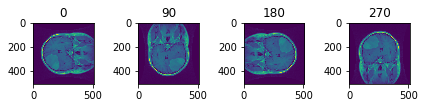

Tumor with 100 neighbors and its 3 rotations


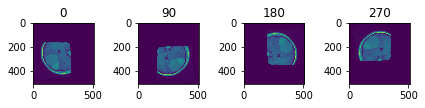

Tumor with 75 neighbors and its 3 rotations


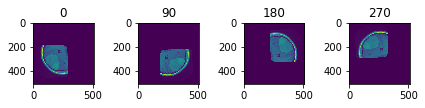

Tumor with 50 neighbors and its 3 rotations


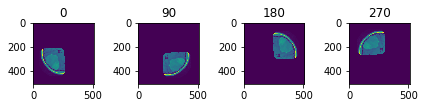

Tumor with 40 neighbors and its 3 rotations


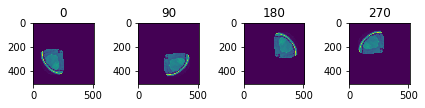

Tumor with 32 neighbors and its 3 rotations


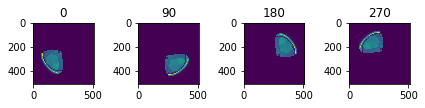

Tumor with 24 neighbors and its 3 rotations


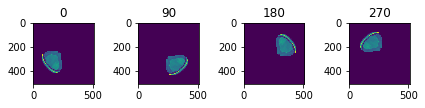

Tumor with 16 neighbors and its 3 rotations


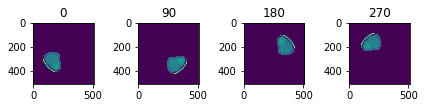

Tumor with 8 neighbors and its 3 rotations


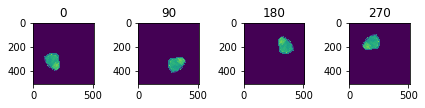

Tumor with 4 neighbors and its 3 rotations


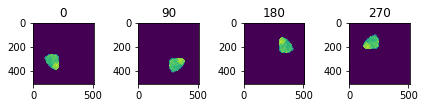

Tumor with 1 neighbor and its 3 rotations


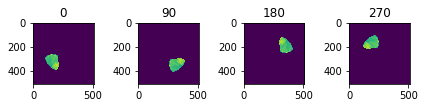


For the Same Patient Diff MRI Images Available are as Below: 



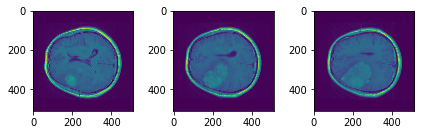

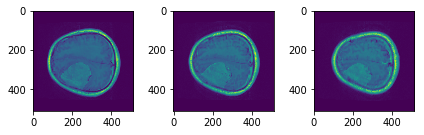

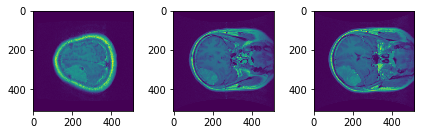

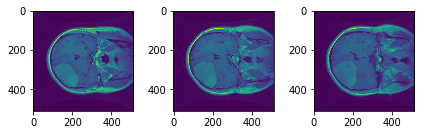

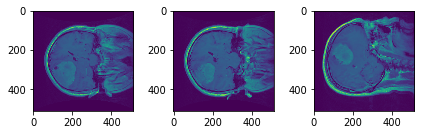

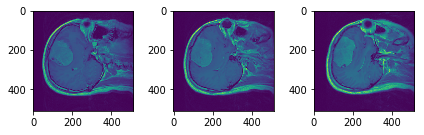

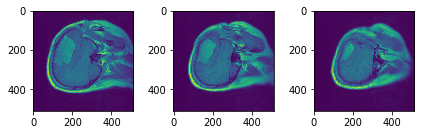

In [8]:
#Let us see the Data; also how it is fed to neural network and related data available

display_random_data()

In [3]:
#Global Variables

# neighbor_list would determine how many crops of the original image has to be done to increase the image dataset size.
neighbor_list = [100, 75, 50, 40, 32, 24, 16, 8, 4, 1, 0]

#following 80:20 rule for training:validation/testing set
test_size = 20 #20%
valid_size = 20 #20%

#batch_size 30 would yeild 30 x 11 x 4 x 512 x 512 x 1  = 1320 images ~ 1.3GB
# where      30 = images
#            11 = crops as determined by neighbor_list
#             4 = 0, 90, 180 ,270 degree of rotation
# 512 x 512 x 1 = 2d input image (512x512) scaled to 3d

batch_size = 30
epochs = 5
keep_probability = 0.5

In [4]:
#let us load all the file identifier in our memory; later these file ids would be to fetch actual image .
#Note that we are doing this to reduce memory consumption as our batch is of size 1.3GB

create_list("brainTumorDataPublic_1-766",1,766)
create_list("brainTumorDataPublic_767-1532",767,1532)
create_list("brainTumorDataPublic_1533-2298",1533,2298)
create_list("brainTumorDataPublic_2299-3064",2299,3064)

meningioma :  (705, 3) glioma :  (53, 3) pituitary :  (7, 3) 

Skipping:  brainTumorDataPublic_767-1532  FileID:  955 of image shape :  (256, 256) Tumor :  3
Skipping:  brainTumorDataPublic_767-1532  FileID:  956 of image shape :  (256, 256) Tumor :  3
Skipping:  brainTumorDataPublic_767-1532  FileID:  957 of image shape :  (256, 256) Tumor :  3
Skipping:  brainTumorDataPublic_767-1532  FileID:  1070 of image shape :  (256, 256) Tumor :  3
Skipping:  brainTumorDataPublic_767-1532  FileID:  1071 of image shape :  (256, 256) Tumor :  3
Skipping:  brainTumorDataPublic_767-1532  FileID:  1072 of image shape :  (256, 256) Tumor :  3
Skipping:  brainTumorDataPublic_767-1532  FileID:  1073 of image shape :  (256, 256) Tumor :  3
Skipping:  brainTumorDataPublic_767-1532  FileID:  1074 of image shape :  (256, 256) Tumor :  3
Skipping:  brainTumorDataPublic_767-1532  FileID:  1075 of image shape :  (256, 256) Tumor :  3
Skipping:  brainTumorDataPublic_767-1532  FileID:  1076 of image shape :  (2

In [5]:
#let us first take out file ids of testing set and keep it far away from training set.

create_test_set(test_size)

print ("Testing Sample Size : ", (np.array(test_fid)).shape)

print ("Training Samples:\nmeningioma : ", np.array(meningioma).shape,\
           "glioma : ", np.array(glioma).shape, \
           "pituitary : ", np.array(pituitary).shape,"\n")

Testing Sample Size :  (423, 3)
Training Samples:
meningioma :  (566, 3) glioma :  (1283, 3) pituitary :  (773, 3) 



In [6]:
##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((512, 512,1))
y = neural_net_label_input(1)
keep_prob = neural_net_keep_prob_input()
is_training = neural_is_training()


# Model
#logits = googlenet(x, keep_prob, 3, is_training)
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y, name='xentropy'))
optimizer = tf.train.AdamOptimizer(learning_rate=10**-6).minimize(cost)

# Accuracy
#correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
correct_pred = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

The ConvNet Model


In [7]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    for i in range(feature_batch.shape[0]):
        session.run(optimizer, feed_dict={
                x: feature_batch[i], 
                y: label_batch[i], 
                keep_prob: keep_probability,
                is_training: True,})

In [ ]:
def print_stats(session, feature_batch, label_batch, valid_features, valid_labels, cost, accuracy, print_lo=0):
    
    feature_batch1 = np.array(feature_batch[0])
    feature_batch2 = feature_batch1[:, :, :, np.newaxis]
    
    valid_features1 = np.array(valid_features)
    valid_features2 = valid_features1[:, :, :,np.newaxis]
    
    if print_lo :
        loss = session.run(cost, feed_dict={
            x: feature_batch2, 
            y: label_batch[0],
            keep_prob: 1.,
            is_training: False,
        })
        valid_acc = session.run(accuracy, feed_dict={
            x: valid_features2,
            y: valid_labels,
            keep_prob: 1.,
            is_training: False,
        })
        print ("Actuals : \n",valid_labels)
        print ("predictions : ")
        print (session.run(correct_pred, feed_dict={
            x: valid_features2,
            y: valid_labels,
            keep_prob: 1.,
            is_training: False,
        }))

        print ("logits : ")
        print (session.run(logits, feed_dict={
            x: valid_features2,
            y: valid_labels,
            keep_prob: 1.,
            is_training: False,
        }))

        print('Loss: {:>10.8f} | Validation Accuracy: {:.8f}'.format(
        loss,
        valid_acc))
        return [loss,valid_acc]
    else:
        loss = session.run(cost, feed_dict={
            x: feature_batch2, 
            y: label_batch[0],
            keep_prob: 1.,
            is_training: False,
        })
        valid_acc = session.run(accuracy, feed_dict={
            x: valid_features2,
            y: valid_labels,
            keep_prob: 1.,
            is_training: False,
        })
        print('Loss: {:>10.8f} | Validation Accuracy: {:.8f}'.format(
        loss,
        valid_acc))
        return [loss,valid_acc]


In [ ]:
#Single Batch multiple runs

save_model_path = './tumor_classification_'+ str(random.randint(1,1000))
epochs = 251

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())

    start_t = time.clock()
    valid_features, valid_labels = get_validation(batch_size,valid_size)
    print ("validation shape: ", np.array(valid_features).shape, np.array(valid_labels).shape)

    batch_features, batch_labels = get_a_batch(batch_size, neighbor_list)
    feat_batch_final, label_batch_final = image_multiplier (batch_features, batch_labels, neighbor_list)
    print ("load time: ", time.clock()-start_t)

    # Training cycle
    for epoch in range(epochs):

        batch_i = 1

        if epoch % 25 == 0:
            print('Time: {}, Epoch {:>3}, MRI Batch {}:  '.format(datetime.datetime.now(), epoch + 1, batch_i), end='')
            train_neural_network(sess, optimizer, keep_probability, feat_batch_final, label_batch_final)            
            print_stats(sess, batch_features, batch_labels, valid_features, valid_labels, cost, accuracy)
        else:
            train_neural_network(sess, optimizer, keep_probability, feat_batch_final, label_batch_final)

        # Save Model
        if epoch == 0:
            print("Save/overwrite the model after each batch in ", save_model_path)
        saver = tf.train.Saver(max_to_keep=1)
        tf.add_to_collection('logits', logits)
        save_path = saver.save(sess, save_model_path)

validation shape:  (6, 512, 512) (6,)
load time:  349.918205
Time: 2018-01-16 03:13:37.394615, Epoch   1, MRI Batch 1:  Loss: 1.02236962 | Validation Accuracy: 0.33333334
Save/overwrite the model after each batch in  ./tumor_classification_430
Time: 2018-01-16 03:31:14.749991, Epoch  26, MRI Batch 1:  Loss: 0.09080190 | Validation Accuracy: 0.33333334
Time: 2018-01-16 03:48:57.168727, Epoch  51, MRI Batch 1:  Loss: 0.03800249 | Validation Accuracy: 0.33333334
Time: 2018-01-16 05:25:57.059334, Epoch  76, MRI Batch 1:  Loss: 0.04906999 | Validation Accuracy: 0.33333334
Time: 2018-01-16 07:13:16.606234, Epoch 101, MRI Batch 1:  Loss: 0.07394248 | Validation Accuracy: 0.50000000
Time: 2018-01-16 09:00:15.535119, Epoch 126, MRI Batch 1:  Loss: 0.10467250 | Validation Accuracy: 0.16666667
Time: 2018-01-16 10:47:17.132671, Epoch 151, MRI Batch 1:  Loss: 0.11718926 | Validation Accuracy: 0.16666667


In [ ]:
#get the test set images
for i in range(len(test_fid)):
    
    global test_features, test_labels
    
    image1 = np.array(get_image(test_fid[i][0],test_fid[i][1], 0))
    test_features.append(image1[:,:,np.newaxis])
    #test_labels.append(one_hot_encode(test_fid[i][2]))
    test_labels.append(test_fid[i][2])
    
print ("Test Features: ", len(test_features), "  Test Labels: ", len(test_labels))


test_model(save_model_path, test_features, test_labels)

In [ ]:
#run all batch and save the new model
save_model_path = './tumor_classification_'+ str(random.randint(1,1000))
epochs = 2

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())

    # Training cycle
    for epoch in range(epochs):
        batch_i = 0

        global valid_features, valid_labels
        valid_features, valid_labels = get_validation(batch_size,valid_size)
        #print ("validation shape: ", np.array(valid_features).shape, np.array(valid_labels).shape)

        # Loop over all batches
        #global meningioma_bk, glioma_bk, pituitary_bk
        #print( meningioma_bk, glioma_bk, pituitary_bk)
        while check_if_batch_is_feasible(batch_size):

            batch_features, batch_labels = get_a_batch(batch_size, neighbor_list)
            feat_batch_final, label_batch_final = image_multiplier (batch_features, batch_labels, neighbor_list)

            train_neural_network(sess, optimizer, keep_probability, feat_batch_final, label_batch_final)

            if batch_i % 11 == 0 :
                print('Time: {}, Epoch {:>2}, MRI Batch {:>2}:  '\
                      .format(datetime.datetime.now(), epoch + 1, batch_i+1), end='')
                print_stats(sess, batch_features, batch_labels, valid_features, valid_labels, cost, accuracy)

            batch_i += 1


            # Save Model
            if epoch == 0:
                print("Save/overwrite the model after each batch in ", save_model_path)
            saver = tf.train.Saver(max_to_keep=1)
            tf.add_to_collection('logits', logits)
            save_path = saver.save(sess, save_model_path)

test_model(save_model_path, test_features, test_labels)